***Making Imports***

In [12]:
import numpy as np
import nibabel as nib
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
import torch
from torch.utils.data import Dataset

**Checking Data**

In [13]:
TRAIN_DATASET_PATH = 'Task01_BrainTumour/imagesTr/'
LABELS_PATH = 'Task01_BrainTumour/labelsTr/'


test_image=nib.load(TRAIN_DATASET_PATH + 'BRATS_458.nii.gz').get_fdata()
print(test_image.max())
#Scalers are applied to 1D so let us reshape and then reshape back to original shape. 
# Normalize each modality separately
for i in range(test_image.shape[-1]):  
    test_image[..., i] = scaler.fit_transform(test_image[..., i].reshape(-1, 1)).reshape(test_image[..., i].shape)
# test_image = scaler.fit_transform(test_image.reshape(-1, test_image.shape[-1])).reshape(test_image.shape)
print(test_image.shape)


test_mask=nib.load(LABELS_PATH + 'BRATS_458.nii.gz').get_fdata()
test_mask=test_mask.astype(np.uint8)

print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)



test_image = test_image[56:184, 56:184, 13:141]
print(test_image.shape)

test_mask = test_mask[56:184, 56:184, 13:141]
print(test_mask.shape)


1377.0
(240, 240, 155, 4)
[0 1 2 3]
(128, 128, 128, 4)
(128, 128, 128)


***Making Dataset Class***

In [15]:
class BrainTumorDataset(Dataset):
    def __init__(self, image_paths, mask_paths):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.scaler = MinMaxScaler()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        # Load the image and mask
        image = nib.load(image_path).get_fdata()
        mask = nib.load(mask_path).get_fdata().astype(np.uint8)

        # Normalize image
        image = self.scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)

        # Apply Cropping
        image = image[56:184, 56:184, 13:141]  # Cropping brain region
        mask = mask[56:184, 56:184, 13:141]    # Cropping corresponding labels

        # Convert to PyTorch Tensor and rearrange dimensions
        image = torch.tensor(image, dtype=torch.float32).permute(3, 2, 0, 1)  # Shape (4, 128, 128, 128)
        mask = torch.tensor(mask, dtype=torch.long)  # Shape (128, 128, 128)

        return image, mask


**Imports for Training**

In [16]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import nibabel as nib
import matplotlib.pyplot as plt
from medpy.metric.binary import hd95, dc
from sklearn.model_selection import KFold
# from segmentation_models_pytorch import Unet
import torch.nn.functional as F
from monai.networks.nets import UNet
from monai.losses import DiceLoss
import segmentation_models_pytorch as sm
from tqdm import tqdm

**1st Stage Training**

In [8]:

loss_function = DiceLoss(to_onehot_y=True, smooth_nr=0, smooth_dr=1e-5, squared_pred=True, sigmoid=True)

# Training function
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    progress = tqdm(train_loader, desc="Training")
    for images, masks in progress:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        masks = masks.unsqueeze(1)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

# Evaluation function
def evaluate(model, val_loader, device):
    model.eval()
    dice_scores = {"ET": [], "TC": [], "WT": []}
    hausdorff_distances = {"ET": [], "TC": [], "WT": []}

    with torch.no_grad():
        progress = tqdm(val_loader, desc="Validating")
        for images, masks in progress:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for label, key in zip([3, (1, 3), (1, 2, 3)], ["ET", "TC", "WT"]):
                gt = torch.isin(masks, torch.tensor(label, device=device)).cpu().numpy()
                pred = torch.isin(preds, torch.tensor(label, device=device)).cpu().numpy()
                if np.sum(pred) == 0 and np.sum(gt) == 0:
                    continue
                elif np.sum(pred) == 0 or np.sum(gt) == 0:
                    continue
                dice_scores[key].append(dc(pred, gt))
                hausdorff_distances[key].append(hd95(pred, gt))

    return {key: np.mean(dice_scores[key]) for key in dice_scores}, {key: np.mean(hausdorff_distances[key]) for key in hausdorff_distances}

# Load data
image_paths = sorted([os.path.join("Task01_BrainTumour/imagesTr", f) for f in os.listdir("Task01_BrainTumour/imagesTr")])
mask_paths = sorted([os.path.join("Task01_BrainTumour/labelsTr", f) for f in os.listdir("Task01_BrainTumour/labelsTr")])

# 5-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_dice_scores = {"ET": [], "TC": [], "WT": []}
all_hd_scores = {"ET": [], "TC": [], "WT": []}
loss_history = {fold: [] for fold in range(5)}

for fold, (train_idx, val_idx) in enumerate(kf.split(image_paths)):
    print(f"Fold {fold+1}/5")
    train_dataset = BrainTumorDataset([image_paths[i] for i in train_idx], [mask_paths[i] for i in train_idx])
    val_dataset = BrainTumorDataset([image_paths[i] for i in val_idx], [mask_paths[i] for i in val_idx])

    train_loader = data.DataLoader(train_dataset, batch_size=2, shuffle=True)
    val_loader = data.DataLoader(val_dataset, batch_size=2, shuffle=False)

    model = UNet(
        spatial_dims=3, in_channels=4, out_channels=4,
        channels=(16, 32, 64, 128, 256), strides=(2, 2, 2, 2), num_res_units=2
    ).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    best_dice = {"ET": 0.0, "TC": 0.0, "WT": 0.0}
    best_hd = {"ET": float('inf'), "TC": float('inf'), "WT": float('inf')}
    best_model_path = f"best_model_fold_{fold+1}.pth"

    for epoch in range(15):
        train_loss = train(model, train_loader, optimizer, loss_function, device)
        loss_history[fold].append(train_loss)

        dice_scores, hausdorff_distances = evaluate(model, val_loader, device)

        # Save model based on best scores for each category
        save_model = False
        for key in dice_scores:
            if dice_scores[key] > best_dice[key]:
                best_dice[key] = dice_scores[key]
                save_model = True
            if hausdorff_distances[key] < best_hd[key]:  # Lower HD is better
                best_hd[key] = hausdorff_distances[key]
                save_model = True

        if save_model:
            torch.save(model.state_dict(), best_model_path)

        print(f"Epoch {epoch+1}: Loss {train_loss:.4f}, Dice {dice_scores}, HD95 {hausdorff_distances}")

    # Store best values for this fold
    for key in best_dice:
        all_dice_scores[key].append(best_dice[key])
        all_hd_scores[key].append(best_hd[key])

# Print final averaged performance across folds
for key in all_dice_scores:
    print(f"Final Dice Score for {key}: {np.mean(all_dice_scores[key]):.4f} ± {np.std(all_dice_scores[key]):.4f}")
    print(f"Final Hausdorff Distance for {key}: {np.mean(all_hd_scores[key]):.4f} ± {np.std(all_hd_scores[key]):.4f}")

# Save loss history for plotting
np.save("loss_history.npy", loss_history)


Fold 1/5


Validating: 100%|██████████| 49/49 [06:08<00:00,  7.52s/it]


Epoch 1: Loss 0.7218, Dice {'ET': 0.09458630243256749, 'TC': 0.29849460535160866, 'WT': 0.2594978516834096}, HD95 {'ET': 50.69996789045374, 'TC': 33.278808950388196, 'WT': 46.28289147187496}


Validating: 100%|██████████| 49/49 [06:01<00:00,  7.38s/it]


Epoch 2: Loss 0.6726, Dice {'ET': 0.15730234003291862, 'TC': 0.4404970196848552, 'WT': 0.4860239368485719}, HD95 {'ET': 33.575554412392115, 'TC': 18.09727527006367, 'WT': 19.055156296488693}


Validating: 100%|██████████| 49/49 [05:55<00:00,  7.25s/it]


Epoch 3: Loss 0.6315, Dice {'ET': 0.1890619845984235, 'TC': 0.48886929267014523, 'WT': 0.5484538695950427}, HD95 {'ET': 30.05901716756348, 'TC': 15.819067451635304, 'WT': 15.31168053326286}


Validating: 100%|██████████| 49/49 [05:41<00:00,  6.97s/it]


Epoch 4: Loss 0.5923, Dice {'ET': 0.2579321381803356, 'TC': 0.4994918576422336, 'WT': 0.5763936892685575}, HD95 {'ET': 20.761680583159087, 'TC': 13.152201427093503, 'WT': 12.930687054384352}


Validating: 100%|██████████| 49/49 [05:55<00:00,  7.25s/it]


Epoch 5: Loss 0.5367, Dice {'ET': 0.25345934694808103, 'TC': 0.46047628548901004, 'WT': 0.544245920281665}, HD95 {'ET': 19.871943428076293, 'TC': 15.154916844244555, 'WT': 14.74259909783059}


Validating: 100%|██████████| 49/49 [05:36<00:00,  6.86s/it]


Epoch 6: Loss 0.5086, Dice {'ET': 0.2599902158592614, 'TC': 0.49673554224229904, 'WT': 0.5866729219698993}, HD95 {'ET': 17.681072915661037, 'TC': 13.333704275594666, 'WT': 12.917890306697672}


Validating: 100%|██████████| 49/49 [05:56<00:00,  7.27s/it]


Epoch 7: Loss 0.4827, Dice {'ET': 0.26140063965955035, 'TC': 0.515022415922343, 'WT': 0.6102233387693693}, HD95 {'ET': 15.642274256161578, 'TC': 13.908558446216059, 'WT': 13.466269119719115}


Validating: 100%|██████████| 49/49 [06:04<00:00,  7.44s/it]


Epoch 8: Loss 0.4673, Dice {'ET': 0.26907669055889616, 'TC': 0.5128307239042615, 'WT': 0.6085628912951213}, HD95 {'ET': 16.929911565758495, 'TC': 14.126523685943729, 'WT': 13.682189476420788}


Validating: 100%|██████████| 49/49 [05:47<00:00,  7.09s/it]


Epoch 9: Loss 0.4596, Dice {'ET': 0.2609829797076191, 'TC': 0.5111133253865249, 'WT': 0.6064367467177751}, HD95 {'ET': 16.67537916995567, 'TC': 15.13475947296294, 'WT': 14.627714692765327}


Validating: 100%|██████████| 49/49 [06:04<00:00,  7.44s/it]


Epoch 10: Loss 0.4447, Dice {'ET': 0.3028114060067127, 'TC': 0.5336644215622225, 'WT': 0.6361351972821132}, HD95 {'ET': 15.779524717017773, 'TC': 12.713121080117041, 'WT': 12.184343968016604}


Validating: 100%|██████████| 49/49 [05:46<00:00,  7.07s/it]


Epoch 11: Loss 0.4278, Dice {'ET': 0.3407527093277361, 'TC': 0.5345732873062079, 'WT': 0.6363994987224704}, HD95 {'ET': 14.947767962507148, 'TC': 15.33334651800137, 'WT': 14.889575574488088}


Validating: 100%|██████████| 49/49 [06:04<00:00,  7.45s/it]


Epoch 12: Loss 0.4245, Dice {'ET': 0.3322341266924216, 'TC': 0.5670261766176576, 'WT': 0.6650743070264005}, HD95 {'ET': 14.761145513612211, 'TC': 13.271897610412218, 'WT': 12.854516708623251}


Validating: 100%|██████████| 49/49 [06:02<00:00,  7.41s/it]


Epoch 13: Loss 0.4158, Dice {'ET': 0.2835829877208727, 'TC': 0.5230606932965913, 'WT': 0.6332798552246799}, HD95 {'ET': 14.185559764116965, 'TC': 15.085073187056292, 'WT': 14.55323398702455}


Validating: 100%|██████████| 49/49 [06:05<00:00,  7.45s/it]


Epoch 14: Loss 0.4005, Dice {'ET': 0.3256497732595243, 'TC': 0.5738777510036741, 'WT': 0.6682855557410575}, HD95 {'ET': 13.990587074243676, 'TC': 10.662180814357543, 'WT': 10.228332762864628}


Validating: 100%|██████████| 49/49 [06:20<00:00,  7.76s/it]


Epoch 15: Loss 0.3914, Dice {'ET': 0.3454073683599703, 'TC': 0.5802124156157882, 'WT': 0.6777314385566184}, HD95 {'ET': 13.550465219141154, 'TC': 10.784452352755268, 'WT': 10.315360865644788}
Fold 2/5


Validating: 100%|██████████| 49/49 [06:37<00:00,  8.10s/it]


Epoch 1: Loss 0.7355, Dice {'ET': 0.011797987732230404, 'TC': 0.1504106769437818, 'WT': 0.18740279929367173}, HD95 {'ET': 75.66131322667171, 'TC': 55.582302018664976, 'WT': 54.89912965750067}


Validating: 100%|██████████| 49/49 [05:49<00:00,  7.13s/it]


Epoch 2: Loss 0.6811, Dice {'ET': 0.043296832699416934, 'TC': 0.39944891243719316, 'WT': 0.47525287472317873}, HD95 {'ET': 43.88555049954515, 'TC': 22.1246551813602, 'WT': 21.915388137219136}


Validating: 100%|██████████| 49/49 [05:40<00:00,  6.95s/it]


Epoch 3: Loss 0.6195, Dice {'ET': 0.15522460686570783, 'TC': 0.43083615299269057, 'WT': 0.5043166502822283}, HD95 {'ET': 32.994041712784544, 'TC': 19.00314860126518, 'WT': 18.52903601908899}


Validating: 100%|██████████| 49/49 [05:31<00:00,  6.76s/it]


Epoch 4: Loss 0.5688, Dice {'ET': 0.008975495607210324, 'TC': 0.46845933096395165, 'WT': 0.5521459346502231}, HD95 {'ET': 17.10725902291432, 'TC': 13.646996511226487, 'WT': 13.272437618054553}


Validating: 100%|██████████| 49/49 [05:03<00:00,  6.20s/it]


Epoch 5: Loss 0.5292, Dice {'ET': 6.391336902370665e-05, 'TC': 0.4920592768890244, 'WT': 0.5829750322517667}, HD95 {'ET': 62.1067870561208, 'TC': 15.607460040481321, 'WT': 15.088312379766272}


Validating: 100%|██████████| 49/49 [05:06<00:00,  6.26s/it]


Epoch 6: Loss 0.5083, Dice {'ET': 5.83610937944577e-05, 'TC': 0.5115111792646214, 'WT': 0.6059656419069148}, HD95 {'ET': 62.115716013609564, 'TC': 12.477708396233767, 'WT': 12.030381758662207}


Validating: 100%|██████████| 49/49 [04:48<00:00,  5.88s/it]


Epoch 7: Loss 0.4930, Dice {'ET': 3.339326026408458e-05, 'TC': 0.4653794062682509, 'WT': 0.5598314034827763}, HD95 {'ET': 87.86858024990286, 'TC': 19.720217030595236, 'WT': 19.26473871840298}


Validating: 100%|██████████| 49/49 [04:54<00:00,  6.02s/it]


Epoch 8: Loss 0.4802, Dice {'ET': 6.266706395242556e-05, 'TC': 0.5361758612371871, 'WT': 0.6330028890894844}, HD95 {'ET': 67.57136646366823, 'TC': 12.450296794271669, 'WT': 11.957210700619704}


Validating: 100%|██████████| 49/49 [05:24<00:00,  6.61s/it]


Epoch 9: Loss 0.4717, Dice {'ET': 0.0008301538233068898, 'TC': 0.531265752140954, 'WT': 0.6310426841440276}, HD95 {'ET': 44.88070129376588, 'TC': 11.98660429592713, 'WT': 11.556706446603357}


Validating: 100%|██████████| 49/49 [05:31<00:00,  6.77s/it]


Epoch 10: Loss 0.4558, Dice {'ET': 0.026668984544596378, 'TC': 0.5478052086052533, 'WT': 0.6420812558900026}, HD95 {'ET': 21.53413255150082, 'TC': 11.60258938801434, 'WT': 11.143007838580143}


Validating: 100%|██████████| 49/49 [05:34<00:00,  6.82s/it]


Epoch 11: Loss 0.4482, Dice {'ET': 0.08944044253646431, 'TC': 0.5400565992781076, 'WT': 0.6481015924876609}, HD95 {'ET': 18.759470093582948, 'TC': 9.255526284684464, 'WT': 8.755818341732907}


Validating: 100%|██████████| 49/49 [05:33<00:00,  6.80s/it]


Epoch 12: Loss 0.4374, Dice {'ET': 0.12025386404942118, 'TC': 0.5416740292018986, 'WT': 0.658718522261504}, HD95 {'ET': 16.85086591529441, 'TC': 10.451714430203836, 'WT': 9.456697839369244}


Validating: 100%|██████████| 49/49 [05:33<00:00,  6.80s/it]


Epoch 13: Loss 0.4277, Dice {'ET': 0.09956670205560843, 'TC': 0.5624254664340493, 'WT': 0.6736708151656595}, HD95 {'ET': 23.268682035689974, 'TC': 10.630575243840342, 'WT': 10.018141684319856}


Validating: 100%|██████████| 49/49 [05:35<00:00,  6.85s/it]


Epoch 14: Loss 0.4234, Dice {'ET': 0.19014199673267534, 'TC': 0.5449076207779798, 'WT': 0.676856646022479}, HD95 {'ET': 14.544832929815215, 'TC': 10.18210614317769, 'WT': 9.435614026545567}


Validating: 100%|██████████| 49/49 [05:37<00:00,  6.88s/it]


Epoch 15: Loss 0.4086, Dice {'ET': 0.18874052546323766, 'TC': 0.5529684408474888, 'WT': 0.6780287866224309}, HD95 {'ET': 18.83651068263434, 'TC': 9.440224256142402, 'WT': 8.796552004977926}
Fold 3/5


Validating: 100%|██████████| 49/49 [06:36<00:00,  8.10s/it]


Epoch 1: Loss 0.7317, Dice {'ET': 0.07887892541785409, 'TC': 0.2740799050600377, 'WT': 0.1673175754784347}, HD95 {'ET': 46.01267518349483, 'TC': 32.29368453911631, 'WT': 56.51776250898971}


Validating: 100%|██████████| 49/49 [05:59<00:00,  7.34s/it]


Epoch 2: Loss 0.6847, Dice {'ET': 0.103798843518326, 'TC': 0.3755224808591599, 'WT': 0.3808629429103471}, HD95 {'ET': 36.883296981492016, 'TC': 24.831764420669664, 'WT': 37.6602890445745}


Validating: 100%|██████████| 49/49 [05:41<00:00,  6.97s/it]


Epoch 3: Loss 0.6420, Dice {'ET': 0.07875618931876747, 'TC': 0.4277396000197904, 'WT': 0.4856198130798455}, HD95 {'ET': 24.16033328770635, 'TC': 18.193706449569216, 'WT': 17.531312622367512}


Validating: 100%|██████████| 49/49 [05:35<00:00,  6.84s/it]


Epoch 4: Loss 0.6050, Dice {'ET': 0.015810765094510616, 'TC': 0.4987440177649812, 'WT': 0.5660385212589131}, HD95 {'ET': 21.378170552034398, 'TC': 13.618609506578128, 'WT': 13.22836852335586}


Validating: 100%|██████████| 49/49 [05:32<00:00,  6.78s/it]


Epoch 5: Loss 0.5625, Dice {'ET': 0.0010317604458200277, 'TC': 0.5066312409237042, 'WT': 0.5817128454582361}, HD95 {'ET': 36.02877435454479, 'TC': 11.6262193097572, 'WT': 11.38955545281173}


Validating: 100%|██████████| 49/49 [04:50<00:00,  5.93s/it]


Epoch 6: Loss 0.5292, Dice {'ET': 3.257063757023044e-05, 'TC': 0.4955176483515362, 'WT': 0.5707036773120284}, HD95 {'ET': 85.04837476732136, 'TC': 13.527481526398272, 'WT': 13.289369363686745}


Validating: 100%|██████████| 49/49 [05:30<00:00,  6.75s/it]


Epoch 7: Loss 0.5042, Dice {'ET': 0.0007533350859504911, 'TC': 0.5047802633481498, 'WT': 0.5784616373625199}, HD95 {'ET': 45.87570940291582, 'TC': 13.65683349463797, 'WT': 13.428179879755469}


Validating: 100%|██████████| 49/49 [05:38<00:00,  6.90s/it]


Epoch 8: Loss 0.4852, Dice {'ET': 0.1894021890595852, 'TC': 0.5150508083536357, 'WT': 0.5966628881154808}, HD95 {'ET': 17.24785600728637, 'TC': 11.412685535106931, 'WT': 11.150390845040953}


Validating: 100%|██████████| 49/49 [05:37<00:00,  6.89s/it]


Epoch 9: Loss 0.4747, Dice {'ET': 0.22041127408320405, 'TC': 0.5269518711798826, 'WT': 0.6118516050228243}, HD95 {'ET': 18.99371505777798, 'TC': 11.701889816686428, 'WT': 11.35654694800389}


Validating: 100%|██████████| 49/49 [05:36<00:00,  6.88s/it]


Epoch 10: Loss 0.4603, Dice {'ET': 0.2320302396719421, 'TC': 0.5414807339867571, 'WT': 0.6246830333179724}, HD95 {'ET': 16.106186316992986, 'TC': 11.681784019426143, 'WT': 11.33794355789013}


Validating: 100%|██████████| 49/49 [05:37<00:00,  6.90s/it]


Epoch 11: Loss 0.4499, Dice {'ET': 0.2647034287467197, 'TC': 0.5520644199223846, 'WT': 0.6443977209534446}, HD95 {'ET': 17.865553102970136, 'TC': 9.832758401673617, 'WT': 9.511263867566054}


Validating: 100%|██████████| 49/49 [05:36<00:00,  6.87s/it]


Epoch 12: Loss 0.4394, Dice {'ET': 0.29883759442831015, 'TC': 0.5602224875046193, 'WT': 0.6421469689982834}, HD95 {'ET': 16.076211223748356, 'TC': 9.889543253087469, 'WT': 9.665992231719635}


Validating: 100%|██████████| 49/49 [05:41<00:00,  6.98s/it]


Epoch 13: Loss 0.4325, Dice {'ET': 0.31182568112007114, 'TC': 0.5507624710680463, 'WT': 0.651757684973288}, HD95 {'ET': 13.399454744401652, 'TC': 8.58595232437408, 'WT': 8.147321354099855}


Validating: 100%|██████████| 49/49 [05:38<00:00,  6.91s/it]


Epoch 14: Loss 0.4245, Dice {'ET': 0.3209561293959159, 'TC': 0.5820489171849315, 'WT': 0.6684686843311332}, HD95 {'ET': 17.365736557457303, 'TC': 9.786430891050504, 'WT': 9.541255293012625}


Validating: 100%|██████████| 49/49 [06:00<00:00,  7.35s/it]


Epoch 15: Loss 0.4150, Dice {'ET': 0.3042512897774614, 'TC': 0.5637640892060105, 'WT': 0.6646471289112013}, HD95 {'ET': 15.704101411070491, 'TC': 9.780960386595236, 'WT': 9.324477367419433}
Fold 4/5


Validating: 100%|██████████| 49/49 [06:37<00:00,  8.11s/it]


Epoch 1: Loss 0.7237, Dice {'ET': 0.02048235235366468, 'TC': 0.3116850245990338, 'WT': 0.2949315154326337}, HD95 {'ET': 48.883466059508564, 'TC': 34.88579911940574, 'WT': 43.91623200308916}


Validating: 100%|██████████| 49/49 [05:54<00:00,  7.24s/it]


Epoch 2: Loss 0.6747, Dice {'ET': 0.005235837014867, 'TC': 0.4387225541045221, 'WT': 0.519849966456743}, HD95 {'ET': 27.84678187249691, 'TC': 16.493398903451542, 'WT': 16.3428077017548}


Validating: 100%|██████████| 49/49 [05:41<00:00,  6.97s/it]


Epoch 3: Loss 0.6349, Dice {'ET': 0.0010703458746946835, 'TC': 0.4762213272020809, 'WT': 0.5768158196410389}, HD95 {'ET': 20.748071456338014, 'TC': 12.723357760230208, 'WT': 12.072364014455085}


Validating: 100%|██████████| 49/49 [05:40<00:00,  6.95s/it]


Epoch 4: Loss 0.5904, Dice {'ET': 0.0006858539497159295, 'TC': 0.47091240887420305, 'WT': 0.5706360414053996}, HD95 {'ET': 30.905765082290433, 'TC': 13.248293765894921, 'WT': 12.926553363447523}


Validating: 100%|██████████| 49/49 [05:15<00:00,  6.43s/it]


Epoch 5: Loss 0.5432, Dice {'ET': 3.354160725767599e-05, 'TC': 0.44872176426989385, 'WT': 0.5494752915292249}, HD95 {'ET': 67.25060419099978, 'TC': 16.213071127678088, 'WT': 15.900331353585262}


Validating: 100%|██████████| 49/49 [05:27<00:00,  6.69s/it]


Epoch 6: Loss 0.5080, Dice {'ET': 4.1202013191725066e-05, 'TC': 0.451882804789966, 'WT': 0.5527286147858026}, HD95 {'ET': 73.55115853805195, 'TC': 14.927943384499358, 'WT': 14.450963809330954}


Validating: 100%|██████████| 49/49 [05:13<00:00,  6.39s/it]


Epoch 7: Loss 0.4797, Dice {'ET': 0.0, 'TC': 0.5019863046531063, 'WT': 0.6117208979139145}, HD95 {'ET': 99.07402481822389, 'TC': 10.686015068582023, 'WT': 10.360058833655994}


Validating: 100%|██████████| 49/49 [05:10<00:00,  6.35s/it]


Epoch 8: Loss 0.4629, Dice {'ET': 0.0, 'TC': 0.4663020545011061, 'WT': 0.5741207846708233}, HD95 {'ET': 96.15612304996495, 'TC': 15.320260236762138, 'WT': 14.782770837108767}


Validating: 100%|██████████| 49/49 [04:51<00:00,  5.94s/it]


Epoch 9: Loss 0.4449, Dice {'ET': 0.0, 'TC': 0.5028881993140991, 'WT': 0.617209409630008}, HD95 {'ET': 121.14364495577169, 'TC': 13.841904445655482, 'WT': 13.274371338373536}


Validating: 100%|██████████| 49/49 [04:55<00:00,  6.04s/it]


Epoch 10: Loss 0.4272, Dice {'ET': 0.0, 'TC': 0.5552394730908347, 'WT': 0.6731201537254325}, HD95 {'ET': 92.84395510748128, 'TC': 10.65019758371875, 'WT': 10.109262557772993}


Validating: 100%|██████████| 49/49 [05:02<00:00,  6.17s/it]


Epoch 11: Loss 0.4126, Dice {'ET': 0.0, 'TC': 0.563292241607258, 'WT': 0.6801945308468911}, HD95 {'ET': 107.17004117624114, 'TC': 10.518167994830232, 'WT': 9.93008905979105}


Validating: 100%|██████████| 49/49 [04:59<00:00,  6.12s/it]


Epoch 12: Loss 0.4049, Dice {'ET': 0.0, 'TC': 0.5527017094456804, 'WT': 0.6678927639065529}, HD95 {'ET': 107.6204252464722, 'TC': 9.587736032339821, 'WT': 9.07828394381596}


Validating: 100%|██████████| 49/49 [05:00<00:00,  6.14s/it]


Epoch 13: Loss 0.3916, Dice {'ET': 0.0, 'TC': 0.5669821758929405, 'WT': 0.6829153442464734}, HD95 {'ET': 123.72610879647765, 'TC': 9.936060036781102, 'WT': 9.199622034067213}


Validating: 100%|██████████| 49/49 [04:59<00:00,  6.12s/it]


Epoch 14: Loss 0.3829, Dice {'ET': 0.0, 'TC': 0.571891894285204, 'WT': 0.6892924613566274}, HD95 {'ET': 79.51100552753688, 'TC': 10.703362274496941, 'WT': 10.000490957656247}


Validating: 100%|██████████| 49/49 [05:01<00:00,  6.16s/it]


Epoch 15: Loss 0.3744, Dice {'ET': 0.0, 'TC': 0.5751413982809173, 'WT': 0.6891832002842291}, HD95 {'ET': 76.14965115954487, 'TC': 11.214713114577908, 'WT': 10.53085477316277}
Fold 5/5


Validating: 100%|██████████| 48/48 [06:38<00:00,  8.30s/it]


Epoch 1: Loss 0.7375, Dice {'ET': 0.07600100078351008, 'TC': 0.3061836063302634, 'WT': 0.19633289798263007}, HD95 {'ET': 50.197655929814026, 'TC': 31.229436995331394, 'WT': 59.94235327958702}


Validating: 100%|██████████| 48/48 [06:20<00:00,  7.93s/it]


Epoch 2: Loss 0.6851, Dice {'ET': 0.10952495405414027, 'TC': 0.426069026412734, 'WT': 0.44908904958660295}, HD95 {'ET': 32.345460604675964, 'TC': 17.700849579920305, 'WT': 26.747667754903333}


Validating: 100%|██████████| 48/48 [06:03<00:00,  7.57s/it]


Epoch 3: Loss 0.6388, Dice {'ET': 0.0006023422641441258, 'TC': 0.4565453224561991, 'WT': 0.5432459318842309}, HD95 {'ET': 27.830037758915136, 'TC': 13.308290473196193, 'WT': 12.507154246476503}


Validating: 100%|██████████| 48/48 [05:37<00:00,  7.04s/it]


Epoch 4: Loss 0.5964, Dice {'ET': 3.3150343437558013e-06, 'TC': 0.4296240510047799, 'WT': 0.5704147059437815}, HD95 {'ET': 79.29231777424394, 'TC': 14.631794903373843, 'WT': 13.884925521819005}


Validating: 100%|██████████| 48/48 [06:05<00:00,  7.61s/it]


Epoch 5: Loss 0.5567, Dice {'ET': 0.0408192481934753, 'TC': 0.4406999219379822, 'WT': 0.5384383241017058}, HD95 {'ET': 24.811804280671975, 'TC': 16.506560100827727, 'WT': 16.130329046747402}


Validating: 100%|██████████| 48/48 [06:02<00:00,  7.56s/it]


Epoch 6: Loss 0.5236, Dice {'ET': 0.04528299447984263, 'TC': 0.47257873484606616, 'WT': 0.5697042345905247}, HD95 {'ET': 25.648030759634793, 'TC': 14.338079896045883, 'WT': 13.937600692181894}


Validating: 100%|██████████| 48/48 [06:17<00:00,  7.87s/it]


Epoch 7: Loss 0.5008, Dice {'ET': 0.18076037328042052, 'TC': 0.45780282916894627, 'WT': 0.5601507646142575}, HD95 {'ET': 22.163509074446306, 'TC': 14.389004717971, 'WT': 14.11943859282878}


Validating: 100%|██████████| 48/48 [05:48<00:00,  7.26s/it]


Epoch 8: Loss 0.4818, Dice {'ET': 0.23021116400844435, 'TC': 0.5030887547458546, 'WT': 0.5825685542398817}, HD95 {'ET': 19.21101619488699, 'TC': 12.634257347420304, 'WT': 12.405515899085664}


Validating: 100%|██████████| 48/48 [05:35<00:00,  6.99s/it]


Epoch 9: Loss 0.4715, Dice {'ET': 0.19887186421761224, 'TC': 0.49925533200936023, 'WT': 0.5840749343145458}, HD95 {'ET': 23.14534788577338, 'TC': 14.15520681517252, 'WT': 13.895244654257567}


Validating: 100%|██████████| 48/48 [05:34<00:00,  6.96s/it]


Epoch 10: Loss 0.4564, Dice {'ET': 0.23857146803074017, 'TC': 0.4748050355323354, 'WT': 0.5581217614877974}, HD95 {'ET': 20.601661814277385, 'TC': 15.875039990107643, 'WT': 15.72580233282178}


Validating: 100%|██████████| 48/48 [05:34<00:00,  6.96s/it]


Epoch 11: Loss 0.4446, Dice {'ET': 0.22926485619162765, 'TC': 0.5073256333652209, 'WT': 0.6035063426069281}, HD95 {'ET': 21.65919180053525, 'TC': 13.247415202435262, 'WT': 13.099265495531142}


Validating: 100%|██████████| 48/48 [05:36<00:00,  7.00s/it]


Epoch 12: Loss 0.4389, Dice {'ET': 0.2853376806283899, 'TC': 0.5466634821785726, 'WT': 0.6351771649102862}, HD95 {'ET': 16.009641813319988, 'TC': 11.267094728616078, 'WT': 10.9051969060325}


Validating: 100%|██████████| 48/48 [05:45<00:00,  7.19s/it]


Epoch 13: Loss 0.4297, Dice {'ET': 0.2925911953106133, 'TC': 0.5570956151294686, 'WT': 0.6513112960713898}, HD95 {'ET': 17.88668116347753, 'TC': 9.997040903186637, 'WT': 9.878212704502769}


Validating: 100%|██████████| 48/48 [06:05<00:00,  7.61s/it]


Epoch 14: Loss 0.4239, Dice {'ET': 0.25824745403025096, 'TC': 0.5454521274937169, 'WT': 0.6511136560190475}, HD95 {'ET': 16.888527527628824, 'TC': 10.645716758953029, 'WT': 10.246272650569487}


Validating: 100%|██████████| 48/48 [06:04<00:00,  7.59s/it]

Epoch 15: Loss 0.4124, Dice {'ET': 0.26165404247984436, 'TC': 0.5209879453389789, 'WT': 0.6138574727723782}, HD95 {'ET': 16.59770623777002, 'TC': 12.54577221194416, 'WT': 12.220218850928545}
Final Dice Score for ET: 0.2339 ± 0.1191
Final Hausdorff Distance for ET: 15.6505 ± 2.7135
Final Dice Score for TC: 0.5714 ± 0.0099
Final Hausdorff Distance for TC: 9.6177 ± 0.6973
Final Dice Score for WT: 0.6730 ± 0.0127
Final Hausdorff Distance for WT: 9.2176 ± 0.7531


**Second batch and if wanted more batch Training**

In [10]:
loss_function = DiceLoss(to_onehot_y=True, smooth_nr=0, smooth_dr=1e-5, squared_pred=True, sigmoid=True)

all_dice_scores = {"ET": [], "TC": [], "WT": []}
all_hd_scores = {"ET": [], "TC": [], "WT": []}
loss_history = {fold: [] for fold in range(5)}

for fold, (train_idx, val_idx) in enumerate(kf.split(image_paths)):
    print(f"Fold {fold+1}/5")
    train_dataset = BrainTumorDataset([image_paths[i] for i in train_idx], [mask_paths[i] for i in train_idx])
    val_dataset = BrainTumorDataset([image_paths[i] for i in val_idx], [mask_paths[i] for i in val_idx])

    train_loader = data.DataLoader(train_dataset, batch_size=2, shuffle=True)
    val_loader = data.DataLoader(val_dataset, batch_size=2, shuffle=False)

    model = UNet(
        spatial_dims=3, in_channels=4, out_channels=4,
        channels=(16, 32, 64, 128, 256), strides=(2, 2, 2, 2), num_res_units=2
    ).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    best_dice = {"ET": 0.0, "TC": 0.0, "WT": 0.0}
    best_hd = {"ET": float('inf'), "TC": float('inf'), "WT": float('inf')}
    best_model_path = f"best_model_fold_{fold+1}.pth"

    # **Load Pre-Saved Model (if exists)**
    if os.path.exists(best_model_path):
        print(f"Loading pre-saved model from {best_model_path} for Fold {fold+1}")
        model.load_state_dict(torch.load(best_model_path))
    
    for epoch in range(15):
        train_loss = train(model, train_loader, optimizer, loss_function, device)
        loss_history[fold].append(train_loss)

        dice_scores, hausdorff_distances = evaluate(model, val_loader, device)

        # Save model based on best scores for each category
        save_model = False
        for key in dice_scores:
            if dice_scores[key] > best_dice[key]:
                best_dice[key] = dice_scores[key]
                save_model = True
            if hausdorff_distances[key] < best_hd[key]:  # Lower HD is better
                best_hd[key] = hausdorff_distances[key]
                save_model = True

        if save_model:
            torch.save(model.state_dict(), best_model_path)

        print(f"Epoch {epoch+1}: Loss {train_loss:.4f}, Dice {dice_scores}, HD95 {hausdorff_distances}")

    # Store best values for this fold
    for key in best_dice:
        all_dice_scores[key].append(best_dice[key])
        all_hd_scores[key].append(best_hd[key])

# Print final averaged performance across folds
for key in all_dice_scores:
    print(f"Final Dice Score for {key}: {np.mean(all_dice_scores[key]):.4f} ± {np.std(all_dice_scores[key]):.4f}")
    print(f"Final Hausdorff Distance for {key}: {np.mean(all_hd_scores[key]):.4f} ± {np.std(all_hd_scores[key]):.4f}")

# Save loss history for plotting
np.save("loss_history.npy", loss_history)


Fold 1/5
Loading pre-saved model from best_model_fold_1.pth for Fold 1


Validating: 100%|██████████| 49/49 [06:14<00:00,  7.65s/it]


Epoch 1: Loss 0.3827, Dice {'ET': 0.35127639180140163, 'TC': 0.5922685346218568, 'WT': 0.6886130664423581}, HD95 {'ET': 14.344469837760245, 'TC': 9.98419668389828, 'WT': 9.548709142433625}


Validating: 100%|██████████| 49/49 [06:14<00:00,  7.65s/it]


Epoch 2: Loss 0.3736, Dice {'ET': 0.3939408153475523, 'TC': 0.599266387672997, 'WT': 0.6922133468741418}, HD95 {'ET': 11.434862970625128, 'TC': 10.106024398441452, 'WT': 9.6647289801271}


Validating: 100%|██████████| 49/49 [06:06<00:00,  7.47s/it]


Epoch 3: Loss 0.3679, Dice {'ET': 0.38226040533351213, 'TC': 0.5883975057845842, 'WT': 0.6836827726828847}, HD95 {'ET': 12.143119649197976, 'TC': 9.686986827448834, 'WT': 9.262081041357728}


Validating: 100%|██████████| 49/49 [06:06<00:00,  7.47s/it]


Epoch 4: Loss 0.3623, Dice {'ET': 0.36942157879996734, 'TC': 0.5861447951435991, 'WT': 0.6815334281488297}, HD95 {'ET': 15.049098672661046, 'TC': 11.717828412258822, 'WT': 11.247385556917198}


Validating: 100%|██████████| 49/49 [06:07<00:00,  7.50s/it]


Epoch 5: Loss 0.3507, Dice {'ET': 0.38816804235504615, 'TC': 0.5948619851012908, 'WT': 0.6892651093201888}, HD95 {'ET': 13.657264549813405, 'TC': 10.538184886822885, 'WT': 10.06390140769337}


Validating: 100%|██████████| 49/49 [06:07<00:00,  7.51s/it]


Epoch 6: Loss 0.3513, Dice {'ET': 0.38958768547496164, 'TC': 0.620144786914451, 'WT': 0.7154538302213798}, HD95 {'ET': 13.25228510671509, 'TC': 8.326278839045228, 'WT': 7.855510939301643}


Validating: 100%|██████████| 49/49 [05:41<00:00,  6.98s/it]


Epoch 7: Loss 0.3459, Dice {'ET': 0.40065484996187184, 'TC': 0.6178250988370663, 'WT': 0.7102169142480722}, HD95 {'ET': 11.472958135911504, 'TC': 9.981746311931433, 'WT': 9.536323824217208}


Validating: 100%|██████████| 49/49 [06:11<00:00,  7.58s/it]


Epoch 8: Loss 0.3421, Dice {'ET': 0.3928685279508555, 'TC': 0.6207229130543926, 'WT': 0.7121470398747229}, HD95 {'ET': 10.908154733660817, 'TC': 8.476272501317453, 'WT': 8.053753176259558}


Validating: 100%|██████████| 49/49 [05:45<00:00,  7.05s/it]


Epoch 9: Loss 0.3340, Dice {'ET': 0.39496299730147105, 'TC': 0.6233949020181907, 'WT': 0.7148876699985867}, HD95 {'ET': 13.587554305668794, 'TC': 11.200154311492375, 'WT': 10.652619598703437}


Validating: 100%|██████████| 49/49 [05:40<00:00,  6.95s/it]


Epoch 10: Loss 0.3289, Dice {'ET': 0.44184159026566405, 'TC': 0.6441554449715569, 'WT': 0.7351125644616254}, HD95 {'ET': 10.189219852436233, 'TC': 7.521246352831095, 'WT': 7.054328777082893}


Validating: 100%|██████████| 49/49 [06:02<00:00,  7.39s/it]


Epoch 11: Loss 0.3207, Dice {'ET': 0.429495013353125, 'TC': 0.6412728417961162, 'WT': 0.7317213491046884}, HD95 {'ET': 10.540165549107902, 'TC': 7.931761848444919, 'WT': 7.433634303661901}


Validating: 100%|██████████| 49/49 [05:38<00:00,  6.91s/it]


Epoch 12: Loss 0.3164, Dice {'ET': 0.3899557662251672, 'TC': 0.636760685973432, 'WT': 0.7266014555955755}, HD95 {'ET': 12.339506251090336, 'TC': 7.792866157480027, 'WT': 7.323151070373149}


Validating: 100%|██████████| 49/49 [05:52<00:00,  7.19s/it]


Epoch 13: Loss 0.3175, Dice {'ET': 0.43456824653076404, 'TC': 0.6478963980795971, 'WT': 0.7381725699561609}, HD95 {'ET': 10.862676078685494, 'TC': 7.925190700006885, 'WT': 7.42373402750431}


Validating: 100%|██████████| 49/49 [05:42<00:00,  6.99s/it]


Epoch 14: Loss 0.3108, Dice {'ET': 0.44136272839846274, 'TC': 0.6480388397371379, 'WT': 0.7385469567188737}, HD95 {'ET': 10.570028691502108, 'TC': 7.750798016165083, 'WT': 7.264555377533953}


Validating: 100%|██████████| 49/49 [05:48<00:00,  7.11s/it]


Epoch 15: Loss 0.3066, Dice {'ET': 0.42925651829036254, 'TC': 0.6537391395361583, 'WT': 0.7442905565038415}, HD95 {'ET': 13.19912556112502, 'TC': 7.621171662056294, 'WT': 7.104744305799041}
Fold 2/5
Loading pre-saved model from best_model_fold_2.pth for Fold 2


Validating: 100%|██████████| 49/49 [05:37<00:00,  6.89s/it]


Epoch 1: Loss 0.4029, Dice {'ET': 0.25097166882519645, 'TC': 0.5594081620953725, 'WT': 0.6888528993127903}, HD95 {'ET': 14.758096432937037, 'TC': 9.282328000519076, 'WT': 8.485539767266602}


Validating: 100%|██████████| 49/49 [05:34<00:00,  6.83s/it]


Epoch 2: Loss 0.3980, Dice {'ET': 0.2232233421490632, 'TC': 0.5565501658340843, 'WT': 0.6723499195772807}, HD95 {'ET': 16.40762971319518, 'TC': 9.601113065077751, 'WT': 9.037927908553055}


Validating: 100%|██████████| 49/49 [05:36<00:00,  6.87s/it]


Epoch 3: Loss 0.3878, Dice {'ET': 0.2860588323920246, 'TC': 0.5468865903514464, 'WT': 0.6729978170741159}, HD95 {'ET': 14.275681764125084, 'TC': 9.610768814743178, 'WT': 8.838727718464114}


Validating: 100%|██████████| 49/49 [05:44<00:00,  7.03s/it]


Epoch 4: Loss 0.3782, Dice {'ET': 0.31131088278805835, 'TC': 0.571840386206248, 'WT': 0.6888963562181456}, HD95 {'ET': 14.85285646668069, 'TC': 9.34322340256882, 'WT': 8.717090479824316}


Validating: 100%|██████████| 49/49 [05:46<00:00,  7.06s/it]


Epoch 5: Loss 0.3793, Dice {'ET': 0.30538253912015795, 'TC': 0.577325169313127, 'WT': 0.6896929542848153}, HD95 {'ET': 16.508584096652548, 'TC': 9.442237511966885, 'WT': 8.812484895720157}


Validating: 100%|██████████| 49/49 [05:39<00:00,  6.93s/it]


Epoch 6: Loss 0.3689, Dice {'ET': 0.33205483950945247, 'TC': 0.5871816873536584, 'WT': 0.6977491085998855}, HD95 {'ET': 16.110592455289737, 'TC': 8.389534219335676, 'WT': 7.741035013744157}


Validating: 100%|██████████| 49/49 [05:32<00:00,  6.78s/it]


Epoch 7: Loss 0.3646, Dice {'ET': 0.22862308996453937, 'TC': 0.5642199444368489, 'WT': 0.6669486722348648}, HD95 {'ET': 26.331020346539855, 'TC': 10.24916318377839, 'WT': 9.715835512777984}


Validating: 100%|██████████| 49/49 [05:35<00:00,  6.85s/it]


Epoch 8: Loss 0.3641, Dice {'ET': 0.3370481870473009, 'TC': 0.5186126265468781, 'WT': 0.632393208895851}, HD95 {'ET': 13.69450551725732, 'TC': 11.700366896442704, 'WT': 11.045542280250146}


Validating: 100%|██████████| 49/49 [05:37<00:00,  6.88s/it]


Epoch 9: Loss 0.3583, Dice {'ET': 0.3634309149633184, 'TC': 0.5956585464754819, 'WT': 0.7045993947551912}, HD95 {'ET': 14.375272601039745, 'TC': 8.50899339151733, 'WT': 7.8791316933404305}


Validating: 100%|██████████| 49/49 [05:36<00:00,  6.86s/it]


Epoch 10: Loss 0.3533, Dice {'ET': 0.363123042096869, 'TC': 0.5810800629374021, 'WT': 0.6883200908267674}, HD95 {'ET': 13.701073894683715, 'TC': 8.717477915314731, 'WT': 8.102852643498856}


Validating: 100%|██████████| 49/49 [05:36<00:00,  6.88s/it]


Epoch 11: Loss 0.3474, Dice {'ET': 0.38540214480169827, 'TC': 0.6080185024160157, 'WT': 0.7093641367860921}, HD95 {'ET': 13.729724775639065, 'TC': 8.028306717331711, 'WT': 7.42037463878042}


Validating: 100%|██████████| 49/49 [05:36<00:00,  6.87s/it]


Epoch 12: Loss 0.3380, Dice {'ET': 0.3907022806526029, 'TC': 0.6091464674533834, 'WT': 0.7153889885611786}, HD95 {'ET': 14.063325327285348, 'TC': 7.9252598435672255, 'WT': 7.325924598411307}


Validating: 100%|██████████| 49/49 [05:35<00:00,  6.84s/it]


Epoch 13: Loss 0.3325, Dice {'ET': 0.385128953657785, 'TC': 0.59254997773786, 'WT': 0.6995036345346738}, HD95 {'ET': 12.847269975842792, 'TC': 8.824315543674764, 'WT': 8.143380203634814}


Validating: 100%|██████████| 49/49 [05:36<00:00,  6.87s/it]


Epoch 14: Loss 0.3302, Dice {'ET': 0.39099214863404386, 'TC': 0.6033871915029028, 'WT': 0.7082667954141862}, HD95 {'ET': 12.935954524833772, 'TC': 8.070427653047284, 'WT': 7.508311541471961}


Validating: 100%|██████████| 49/49 [05:37<00:00,  6.89s/it]


Epoch 15: Loss 0.3249, Dice {'ET': 0.39375409576999965, 'TC': 0.6101793061302796, 'WT': 0.715969816250265}, HD95 {'ET': 13.910632119245848, 'TC': 7.689820490511651, 'WT': 7.081328530360061}
Fold 3/5
Loading pre-saved model from best_model_fold_3.pth for Fold 3


Validating: 100%|██████████| 49/49 [05:40<00:00,  6.94s/it]


Epoch 1: Loss 0.4121, Dice {'ET': 0.30743822911871516, 'TC': 0.5825924947140353, 'WT': 0.6741421752712501}, HD95 {'ET': 16.49788292489886, 'TC': 8.98536513422939, 'WT': 8.651895691154653}


Validating: 100%|██████████| 49/49 [05:38<00:00,  6.91s/it]


Epoch 2: Loss 0.4026, Dice {'ET': 0.3301878595997254, 'TC': 0.5834877692939097, 'WT': 0.6681923647744934}, HD95 {'ET': 14.731250558172118, 'TC': 8.604967380990058, 'WT': 8.221615508311347}


Validating: 100%|██████████| 49/49 [05:39<00:00,  6.94s/it]


Epoch 3: Loss 0.3996, Dice {'ET': 0.3574973201322291, 'TC': 0.5996258319766021, 'WT': 0.6915404194243394}, HD95 {'ET': 12.822783913214002, 'TC': 7.536966919432621, 'WT': 7.171967181964097}


Validating: 100%|██████████| 49/49 [05:49<00:00,  7.13s/it]


Epoch 4: Loss 0.3892, Dice {'ET': 0.3425209675619535, 'TC': 0.6006061165110351, 'WT': 0.6892138965114213}, HD95 {'ET': 13.6368204722845, 'TC': 7.686779680363319, 'WT': 7.309685034536551}


Validating: 100%|██████████| 49/49 [05:52<00:00,  7.19s/it]


Epoch 5: Loss 0.3815, Dice {'ET': 0.3475974355419559, 'TC': 0.5945435001242108, 'WT': 0.6866861252932863}, HD95 {'ET': 14.731753434003139, 'TC': 8.326636124525296, 'WT': 7.9091023550544195}


Validating: 100%|██████████| 49/49 [05:38<00:00,  6.90s/it]


Epoch 6: Loss 0.3799, Dice {'ET': 0.3330201174215929, 'TC': 0.5902997360872709, 'WT': 0.6823794691718694}, HD95 {'ET': 14.336211895176863, 'TC': 7.981196140265073, 'WT': 7.543316072744392}


Validating: 100%|██████████| 49/49 [05:40<00:00,  6.94s/it]


Epoch 7: Loss 0.3764, Dice {'ET': 0.34736261871837487, 'TC': 0.6076817838123936, 'WT': 0.6916546924371373}, HD95 {'ET': 14.911430967125254, 'TC': 7.6777510754790805, 'WT': 7.292776741632469}


Validating: 100%|██████████| 49/49 [05:38<00:00,  6.90s/it]


Epoch 8: Loss 0.3690, Dice {'ET': 0.3077982178318991, 'TC': 0.5938924369446411, 'WT': 0.6855668603498747}, HD95 {'ET': 16.61576665778694, 'TC': 9.067192278838846, 'WT': 8.546774382941548}


Validating: 100%|██████████| 49/49 [06:10<00:00,  7.57s/it]


Epoch 9: Loss 0.3626, Dice {'ET': 0.37610079192425894, 'TC': 0.6024091195380997, 'WT': 0.6913317732412788}, HD95 {'ET': 12.997969747553825, 'TC': 7.877124146730879, 'WT': 7.489912664790499}


Validating: 100%|██████████| 49/49 [05:44<00:00,  7.03s/it]


Epoch 10: Loss 0.3556, Dice {'ET': 0.3964203990809331, 'TC': 0.6194496448516006, 'WT': 0.7053478865818769}, HD95 {'ET': 12.523201243171638, 'TC': 6.714062450952367, 'WT': 6.35710808150351}


Validating: 100%|██████████| 49/49 [05:38<00:00,  6.91s/it]


Epoch 11: Loss 0.3530, Dice {'ET': 0.36655432433742063, 'TC': 0.6127195011719888, 'WT': 0.6968723074795815}, HD95 {'ET': 15.939170816786978, 'TC': 9.306709304664428, 'WT': 8.906469099299938}


Validating: 100%|██████████| 49/49 [05:38<00:00,  6.91s/it]


Epoch 12: Loss 0.3511, Dice {'ET': 0.39108321556106157, 'TC': 0.6227593284871386, 'WT': 0.7090003926713503}, HD95 {'ET': 14.70167730139645, 'TC': 7.3096541084944295, 'WT': 6.881395587782974}


Validating: 100%|██████████| 49/49 [05:38<00:00,  6.92s/it]


Epoch 13: Loss 0.3401, Dice {'ET': 0.41770595123182014, 'TC': 0.625803828669532, 'WT': 0.7120647350199556}, HD95 {'ET': 11.566380723227075, 'TC': 6.831265632683294, 'WT': 6.351208452527071}


Validating: 100%|██████████| 49/49 [05:39<00:00,  6.92s/it]


Epoch 14: Loss 0.3422, Dice {'ET': 0.4129231474473054, 'TC': 0.6340568811614812, 'WT': 0.7168877601879067}, HD95 {'ET': 12.30192933086756, 'TC': 6.280187420797722, 'WT': 5.880347522749427}


Validating: 100%|██████████| 49/49 [05:38<00:00,  6.91s/it]


Epoch 15: Loss 0.3324, Dice {'ET': 0.4208044076473061, 'TC': 0.6171506343574048, 'WT': 0.7037066054308834}, HD95 {'ET': 11.80938966315976, 'TC': 8.060588698039952, 'WT': 7.555716007127751}
Fold 4/5
Loading pre-saved model from best_model_fold_4.pth for Fold 4


Validating: 100%|██████████| 49/49 [04:56<00:00,  6.05s/it]


Epoch 1: Loss 0.3694, Dice {'ET': 0.0, 'TC': 0.5757155613247233, 'WT': 0.6904398889010493}, HD95 {'ET': 67.43788968483746, 'TC': 10.357138513155004, 'WT': 9.734261818634712}


Validating: 100%|██████████| 49/49 [05:03<00:00,  6.20s/it]


Epoch 2: Loss 0.3607, Dice {'ET': 4.636713497472991e-06, 'TC': 0.570068718751536, 'WT': 0.6857627307167189}, HD95 {'ET': 77.30858826493272, 'TC': 11.75046041838893, 'WT': 10.920221834610954}


Validating: 100%|██████████| 49/49 [05:21<00:00,  6.57s/it]


Epoch 3: Loss 0.3556, Dice {'ET': 0.00035403513088566054, 'TC': 0.5616716476206829, 'WT': 0.6787894045533045}, HD95 {'ET': 62.00686244899407, 'TC': 12.01950401088049, 'WT': 11.29830720407378}


Validating: 100%|██████████| 49/49 [05:22<00:00,  6.57s/it]


Epoch 4: Loss 0.3533, Dice {'ET': 0.00013149071564292294, 'TC': 0.5833301747432549, 'WT': 0.7004583112887323}, HD95 {'ET': 62.730402440568064, 'TC': 11.551044787012428, 'WT': 10.93133681070933}


Validating: 100%|██████████| 49/49 [05:32<00:00,  6.79s/it]


Epoch 5: Loss 0.3464, Dice {'ET': 0.001445422609093838, 'TC': 0.5928239210720864, 'WT': 0.7062822337338719}, HD95 {'ET': 60.09918099287989, 'TC': 8.851833773407819, 'WT': 8.223724629321463}


Validating: 100%|██████████| 49/49 [05:37<00:00,  6.88s/it]


Epoch 6: Loss 0.3401, Dice {'ET': 0.025810324040633326, 'TC': 0.5882130505354018, 'WT': 0.7023397206695022}, HD95 {'ET': 47.47912904991416, 'TC': 9.653778049766812, 'WT': 8.908793696157248}


Validating: 100%|██████████| 49/49 [05:39<00:00,  6.94s/it]


Epoch 7: Loss 0.3356, Dice {'ET': 0.2131356019060021, 'TC': 0.5724286973328289, 'WT': 0.7031138497380173}, HD95 {'ET': 19.038047430324006, 'TC': 8.239667233115986, 'WT': 7.561869575896189}


Validating: 100%|██████████| 49/49 [05:40<00:00,  6.95s/it]


Epoch 8: Loss 0.3304, Dice {'ET': 0.277638103161723, 'TC': 0.540177739954737, 'WT': 0.6801791830269333}, HD95 {'ET': 17.796951282367807, 'TC': 8.377510509119553, 'WT': 7.889891968801113}


Validating: 100%|██████████| 49/49 [05:41<00:00,  6.98s/it]


Epoch 9: Loss 0.3229, Dice {'ET': 0.31818302311541574, 'TC': 0.5799411579456079, 'WT': 0.7062909644314541}, HD95 {'ET': 18.748454044811883, 'TC': 7.857963718450201, 'WT': 7.2680029104556665}


Validating: 100%|██████████| 49/49 [05:43<00:00,  7.02s/it]


Epoch 10: Loss 0.3158, Dice {'ET': 0.3324898643622136, 'TC': 0.5896327822840863, 'WT': 0.7089359895959332}, HD95 {'ET': 19.572009054535304, 'TC': 8.019120513361818, 'WT': 7.439811612445178}


Validating: 100%|██████████| 49/49 [05:42<00:00,  6.98s/it]


Epoch 11: Loss 0.3116, Dice {'ET': 0.3560577348652214, 'TC': 0.5908012313628171, 'WT': 0.7071637078981736}, HD95 {'ET': 17.626922482870352, 'TC': 8.009702240750032, 'WT': 7.4143481083194045}


Validating: 100%|██████████| 49/49 [05:40<00:00,  6.95s/it]


Epoch 12: Loss 0.3033, Dice {'ET': 0.33122740701466474, 'TC': 0.6008051864055878, 'WT': 0.7138701070714358}, HD95 {'ET': 22.969807988206227, 'TC': 8.25684166918046, 'WT': 7.595214828872273}


Validating: 100%|██████████| 49/49 [05:44<00:00,  7.03s/it]


Epoch 13: Loss 0.2958, Dice {'ET': 0.36880666157235253, 'TC': 0.5988193262536283, 'WT': 0.7124983264999333}, HD95 {'ET': 20.190336858245367, 'TC': 7.4490146526938705, 'WT': 6.981084227978485}


Validating: 100%|██████████| 49/49 [05:42<00:00,  6.99s/it]


Epoch 14: Loss 0.2935, Dice {'ET': 0.3927928460880225, 'TC': 0.60378290255216, 'WT': 0.7150838845522882}, HD95 {'ET': 16.299852436444198, 'TC': 7.182227729458736, 'WT': 6.674958910877804}


Validating: 100%|██████████| 49/49 [05:42<00:00,  7.00s/it]


Epoch 15: Loss 0.2899, Dice {'ET': 0.36594248478259134, 'TC': 0.6113690151974378, 'WT': 0.7244389335610516}, HD95 {'ET': 18.78655959072425, 'TC': 7.689525219384, 'WT': 6.89898302848699}
Fold 5/5
Loading pre-saved model from best_model_fold_5.pth for Fold 5


Validating: 100%|██████████| 48/48 [05:35<00:00,  6.99s/it]


Epoch 1: Loss 0.4160, Dice {'ET': 0.3100837282634911, 'TC': 0.5515460367415944, 'WT': 0.6390579298841718}, HD95 {'ET': 18.1503427324794, 'TC': 11.739280459873877, 'WT': 11.565770606246895}


Validating: 100%|██████████| 48/48 [05:35<00:00,  6.98s/it]


Epoch 2: Loss 0.4045, Dice {'ET': 0.2670382431194887, 'TC': 0.5566782677891619, 'WT': 0.6551245262291723}, HD95 {'ET': 17.863402568811278, 'TC': 10.48373925211094, 'WT': 10.263265513694929}


Validating: 100%|██████████| 48/48 [05:41<00:00,  7.12s/it]


Epoch 3: Loss 0.4035, Dice {'ET': 0.3156463624282876, 'TC': 0.554045360288759, 'WT': 0.6478321996931018}, HD95 {'ET': 18.161247887154772, 'TC': 11.229062680644693, 'WT': 10.983882077201953}


Validating: 100%|██████████| 48/48 [05:42<00:00,  7.14s/it]


Epoch 4: Loss 0.3944, Dice {'ET': 0.30426670627283914, 'TC': 0.5633111600910388, 'WT': 0.6548499378616057}, HD95 {'ET': 15.836013808553398, 'TC': 9.275924469235859, 'WT': 8.997634471392798}


Validating: 100%|██████████| 48/48 [06:02<00:00,  7.55s/it]


Epoch 5: Loss 0.3868, Dice {'ET': 0.2840805386702748, 'TC': 0.5637280650652982, 'WT': 0.6574562661548532}, HD95 {'ET': 18.31679741303773, 'TC': 10.354092452003872, 'WT': 9.979597838357513}


Validating: 100%|██████████| 48/48 [05:38<00:00,  7.06s/it]


Epoch 6: Loss 0.3816, Dice {'ET': 0.33265705950266744, 'TC': 0.5801875205551482, 'WT': 0.6720429634379146}, HD95 {'ET': 14.82723971023435, 'TC': 8.623416004442754, 'WT': 8.350127211119116}


Validating: 100%|██████████| 48/48 [05:36<00:00,  7.01s/it]


Epoch 7: Loss 0.3751, Dice {'ET': 0.33064288720625234, 'TC': 0.5685108849563254, 'WT': 0.6601014647254332}, HD95 {'ET': 16.812150293634968, 'TC': 10.844313737394748, 'WT': 10.585834620473948}


Validating: 100%|██████████| 48/48 [07:38<00:00,  9.55s/it]


Epoch 8: Loss 0.3701, Dice {'ET': 0.3365077939024986, 'TC': 0.5831041482351862, 'WT': 0.6731720413228861}, HD95 {'ET': 16.281459442713352, 'TC': 9.28522391687413, 'WT': 9.088771284332628}


Validating: 100%|██████████| 48/48 [06:02<00:00,  7.56s/it]


Epoch 9: Loss 0.3709, Dice {'ET': 0.3413142946145316, 'TC': 0.5704412605276036, 'WT': 0.6582891070670195}, HD95 {'ET': 17.13424407015933, 'TC': 9.28378249971781, 'WT': 9.018026915271653}


Validating: 100%|██████████| 48/48 [06:05<00:00,  7.60s/it]


Epoch 10: Loss 0.3637, Dice {'ET': 0.3390334540547775, 'TC': 0.5903959887902249, 'WT': 0.6840732874817732}, HD95 {'ET': 15.946935737462297, 'TC': 8.668372906824901, 'WT': 8.419673443627689}


Validating: 100%|██████████| 48/48 [06:05<00:00,  7.62s/it]


Epoch 11: Loss 0.3558, Dice {'ET': 0.34213854110463066, 'TC': 0.5926405519148029, 'WT': 0.681856396382475}, HD95 {'ET': 16.34318760762824, 'TC': 9.039090069602727, 'WT': 8.799739511745136}


Validating: 100%|██████████| 48/48 [05:37<00:00,  7.03s/it]


Epoch 12: Loss 0.3571, Dice {'ET': 0.3360508224849788, 'TC': 0.5807150074716071, 'WT': 0.6731915672833102}, HD95 {'ET': 16.09096605118732, 'TC': 9.590950038787078, 'WT': 9.356655731715705}


Validating: 100%|██████████| 48/48 [05:46<00:00,  7.22s/it]


Epoch 13: Loss 0.3470, Dice {'ET': 0.3677817629296955, 'TC': 0.5985699179097826, 'WT': 0.6855239496559061}, HD95 {'ET': 14.722611081557067, 'TC': 9.018382171078494, 'WT': 8.422243532823368}


Validating: 100%|██████████| 48/48 [05:50<00:00,  7.30s/it]


Epoch 14: Loss 0.3455, Dice {'ET': 0.3392670994757144, 'TC': 0.5770524285013057, 'WT': 0.6645362269484852}, HD95 {'ET': 18.03277505552014, 'TC': 10.654532422374771, 'WT': 10.201432852257273}


Validating: 100%|██████████| 48/48 [05:37<00:00,  7.03s/it]

Epoch 15: Loss 0.3367, Dice {'ET': 0.3454804530148885, 'TC': 0.5946398853103075, 'WT': 0.6828305692204567}, HD95 {'ET': 15.758484115721231, 'TC': 8.384305399794647, 'WT': 8.082400094695117}
Final Dice Score for ET: 0.4034 ± 0.0255
Final Hausdorff Distance for ET: 13.1251 ± 2.1798
Final Dice Score for TC: 0.6216 ± 0.0198
Final Hausdorff Distance for TC: 7.4116 ± 0.6882
Final Dice Score for WT: 0.7174 ± 0.0189
Final Hausdorff Distance for WT: 6.9547 ± 0.7114


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


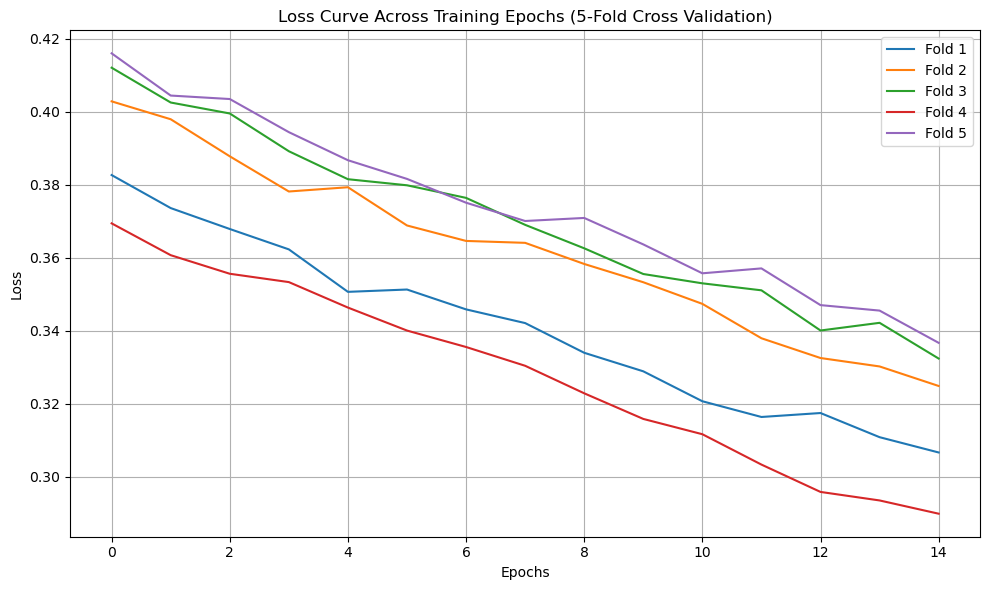

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Load the saved loss history
loss_history = np.load("loss_history.npy", allow_pickle=True).item()

# Plot the loss curves
plt.figure(figsize=(10, 6))

# Plot loss for each fold
for fold in range(5):
    plt.plot(loss_history[fold], label=f'Fold {fold+1}')

plt.title('Loss Curve Across Training Epochs (5-Fold Cross Validation)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

**Data Visualization**

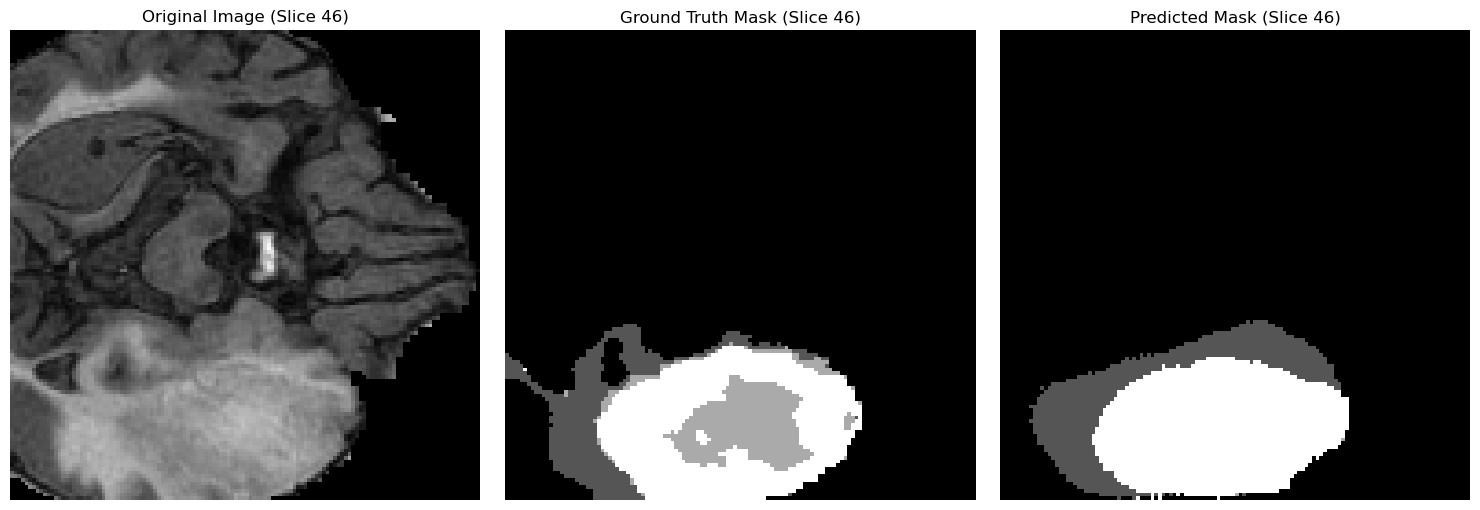

In [21]:
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
        spatial_dims=3, in_channels=4, out_channels=4,
        channels=(16, 32, 64, 128, 256), strides=(2, 2, 2, 2), num_res_units=2
    ).to(device)

best_model_path = f"best_model_fold_1.pth"
# Load data
image_paths = sorted([os.path.join("Task01_BrainTumour/imagesTr", f) for f in os.listdir("Task01_BrainTumour/imagesTr")])
mask_paths = sorted([os.path.join("Task01_BrainTumour/labelsTr", f) for f in os.listdir("Task01_BrainTumour/labelsTr")])

model.load_state_dict(torch.load(best_model_path))

# Load dataset
dataset = BrainTumorDataset(image_paths, mask_paths)  # Ensure paths are correctly set

# Select a random index
random_idx = random.randint(0, len(dataset) - 1)
image, ground_truth_mask = dataset[random_idx]  # Get random sample

# Convert PyTorch tensors to NumPy
image = image.cpu().numpy()  # Shape: (4, 128, 128, 128)
ground_truth_mask = ground_truth_mask.cpu().numpy()  # Shape: (128, 128, 128)

# Load model and get prediction (assuming model is trained)
model.eval()
with torch.no_grad():
    predicted_mask = model(torch.tensor(image).unsqueeze(0))  # Add batch dimension
    predicted_mask = torch.argmax(predicted_mask, dim=1).squeeze(0).cpu().numpy()  # Get class-wise predictions

# Ensure correct shape for ITK-SNAP visualization
# Reorder the image to (depth, height, width, modalities)
image_cropped = np.moveaxis(image, [1, 2, 3, 0], [2, 0, 1, 3])

# Save the original cropped image
nib.save(nib.Nifti1Image(image_cropped, affine=np.eye(4)), "original_image.nii.gz")

# Save the ground truth mask
nib.save(nib.Nifti1Image(ground_truth_mask.astype(np.uint8), affine=np.eye(4)), "ground_truth_mask.nii.gz")

# Save the predicted mask
nib.save(nib.Nifti1Image(predicted_mask.astype(np.uint8), affine=np.eye(4)), "predicted_mask.nii.gz")

# Select a random slice for visualization
slice_idx = random.randint(0, ground_truth_mask.shape[-1] - 1)
gt_slice = ground_truth_mask[:, :, slice_idx]  # Ground truth mask slice
pred_slice = predicted_mask[:, :, slice_idx]  # Predicted mask slice
orig_slice = image[0, slice_idx, :,: ]  # Take first modality of image

# Plot original image, ground truth mask, and predicted mask
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original Image
axes[0].imshow(orig_slice, cmap="gray")
axes[0].set_title(f"Original Image (Slice {slice_idx})")
axes[0].axis("off")

# Ground Truth Mask
axes[1].imshow(gt_slice, cmap="gray")
axes[1].set_title(f"Ground Truth Mask (Slice {slice_idx})")
axes[1].axis("off")

# Predicted Mask
axes[2].imshow(pred_slice, cmap="gray")
axes[2].set_title(f"Predicted Mask (Slice {slice_idx})")
axes[2].axis("off")

plt.tight_layout()
plt.show()
